In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from copy import deepcopy

import numpy as np
import pandas as pd
from rdkit import RDLogger

from divopt.evaluation.process_results import load_results

RDLogger.DisableLog("rdApp.*")

In [3]:
limit_names = ["samples", "time"]
runs_base = "../runs"

results_dict = load_results(runs_base)

In [4]:
def pivot_and_aggregate_results(results, aggfunc, values):
    # Use pivot_table to reshape the DataFrame
    pivot_df = results.pivot_table(index="Optimizer", columns="Task", values=values, aggfunc=aggfunc, dropna=False)
    # Reorder columns if needed
    pivot_df = pivot_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

    # Now, pivot_df has the desired structure.
    first_level = pivot_df.columns.get_level_values(0).unique()
    second_level = values
    new_columns = pd.MultiIndex.from_product([first_level, second_level])
    pivot_df = pivot_df.reindex(columns=new_columns)
    return pivot_df


def get_mean_std_df(results, limit_name="time"):
    results = deepcopy(results)
    solution_names = ["Hits", "DivHits", "NDivHits", "IntDiv"]
    rename_solution_map = dict(
        zip(
            [
                f"n_solutions_{limit_name}",
                f"n_diverse_all_{limit_name}",
                f"n_diverse_novel_{limit_name}",
                f"IntDiv_{limit_name}",
            ],
            solution_names,
        )
    )
    results = results.rename(columns=rename_solution_map)
    pivot_df_ds = pivot_and_aggregate_results(results, aggfunc="mean", values=["DivHits"])
    ranks = pivot_df_ds.rank(axis=0, ascending=False)
    mean_ranks = ranks.mean(axis=1).sort_values()
    pivot_df_mean = pivot_and_aggregate_results(results, aggfunc="mean", values=solution_names)
    pivot_df_std = pivot_and_aggregate_results(results, aggfunc="std", values=solution_names)
    pivot_df_std.fillna(0, inplace=True)

    pivot_df_mean = pivot_df_mean.reindex(mean_ranks.index)
    pivot_df_std = pivot_df_std.reindex(mean_ranks.index)
    return pivot_df_mean, pivot_df_std, ranks

In [5]:
def convert_to_str(df_mean, df_std):
    int_cols = ["Hits", "DivHits", "NDivHits"]
    float_cols = ["IntDiv"]
    idx_int_col = np.array([s in int_cols for s in df_mean.columns.get_level_values(1)])
    idx_float_col = np.array([s in float_cols for s in df_std.columns.get_level_values(1)])

    df_std_perc = df_std / df_mean * 100  # .clip(upper=99)
    df_std_perc.fillna(0, inplace=True)

    df_mean_str = df_mean.copy().astype(object)

    df_mean_str.iloc[:, idx_int_col] = df_mean.iloc[:, idx_int_col].map(lambda x: f"{x:.0f}")
    df_mean_str.iloc[:, idx_float_col] = df_mean.iloc[:, idx_float_col].map(lambda x: f"{x:.2f}")

    df_std_str = df_std.copy().astype(object)
    df_std_str.iloc[:, idx_int_col] = df_std_perc.iloc[:, idx_int_col].map(lambda x: f"{x:.0f}\%")
    df_std_str.iloc[:, idx_float_col] = df_std.iloc[:, idx_float_col].map(lambda x: f"{x:.2f}")

    # pivot_df = pivot_df.map(lambda x: f"${x}$")
    idx_conv2k = df_mean.columns.get_level_values(1) == "Hits"

    def conv2k(x):
        if x > 1000:
            return f"{x/1000:.1f}K"
        else:
            return f"{x:.0f}"

    df_mean_str.iloc[:, idx_conv2k] = df_mean.iloc[:, idx_conv2k].map(conv2k)
    return df_mean_str, df_std_str


def join_mean_std_pd(df_mean_str, df_std_str):
    df_str = df_mean_str + "±" + df_std_str
    return df_str


def join_mean_std_latex(df_mean_str, df_std_str):
    df_mean_str = df_mean_str.copy()
    df_std_str = df_std_str.copy()

    df_mean_str = df_mean_str.map(lambda x: f"${x}$")
    df_std_str = df_std_str.map(lambda x: f"& $^{{\pm{x}}}$")
    return df_mean_str + df_std_str


def get_cmidrule(df_str):
    first_level_cols = df_str.columns.get_level_values(0).unique()
    second_level_cols = df_str.columns.get_level_values(1).unique()

    start_idx = 2
    ranges = []
    for i in range(len(first_level_cols)):
        shift = len(second_level_cols) * 2
        ranges.append(f"{start_idx}-{start_idx+shift-1}")
        start_idx += shift
    return " ".join([f"\\cmidrule(lr){{{r}}}" for r in ranges])


def convert_to_latex_singleindex(pivot_df):
    pivot_df = deepcopy(pivot_df)
    # this escapes for siunitx
    # pivot_df.index = [f"{{{y.strip()}}}" for y in pivot_df.index]
    # pivot_df.columns = pd.MultiIndex.from_tuples([[f"{{{y}}}" for y in x] for x in pivot_df.columns])
    pivot_df.index.name = None
    pivot_df.columns.names = [None, None]
    latex_output = pivot_df.to_latex(
        multicolumn_format="c",
        multirow=True,
        column_format="l" + "r@{}l" * len(pivot_df.columns),
    )

    latex_output = re.sub(r"\\cline\{.*?\}\n", "", latex_output)
    latex_output = latex_output.replace("\\cline{2-3}", "")
    lines = latex_output.splitlines()

    # Define a function to double the matched number
    def double_match(match):
        number = int(match.group())
        doubled_number = number * 2
        return str(doubled_number)

    def double_multicolumn(line):
        return re.sub(r"(?<=multicolumn{)\d+", double_match, line)

    lines[2] = double_multicolumn(lines[2])
    lines.insert(3, get_cmidrule(pivot_df))
    lines[4] = re.sub(r"\w+", lambda match: f"\multicolumn{{2}}{{c}}{{{match.group()}}}", lines[4])

    # midrule_idx = lines.index('\\midrule')
    # start_odd = (midrule_idx+1) % 2
    # bottom_rule_idx = lines.index('\\bottomrule')
    # for i in range(midrule_idx+1, bottom_rule_idx):
    #     if (i+start_odd) % 2 == 0:
    #         lines[i] = "\\rowcolor[gray]{0.9}" + lines[i]
    # lines.insert(-4, "\\midrule")
    return "\n".join(lines)

In [6]:
ranks_dict = {}
latex_tables = {}
pd_tables = {}
df_mean_dict = {}
for limit_name in ["samples", "time"]:
    results = results_dict[limit_name]
    df_mean, df_std, ranks = get_mean_std_df(results, limit_name=limit_name)
    df_mean_dict[limit_name] = df_mean
    ranks_dict[limit_name] = ranks
    df_mean_str, df_std_str = convert_to_str(df_mean, df_std)
    df_str_latex = join_mean_std_latex(df_mean_str, df_std_str)
    df_str_pd = join_mean_std_pd(df_mean_str, df_std_str)
    idx = df_str_latex.columns.get_level_values(1) != "Hits"
    df_str_latex = df_str_latex.iloc[:, idx]
    latex_str = convert_to_latex_singleindex(df_str_latex)
    latex_str = latex_str.replace("β", r"$\beta$")
    latex_tables[limit_name] = latex_str
    pd_tables[limit_name] = df_str_pd

In [7]:
for limit_name, latex_str in latex_tables.items():
    with open(f"tables/results_allmetrics_{limit_name}.tex", "w") as f:
        f.write(latex_str)

In [8]:
display(pd_tables["samples"].applymap(lambda x: x.replace("\\", "")))
display(pd_tables["time"].applymap(lambda x: x.replace("\\", "")))

/tmp/ipykernel_63030/3900719213.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(pd_tables["samples"].applymap(lambda x: x.replace("\\", "")))


Task             DRD2                                 GSK3β                    \
                 Hits DivHits NDivHits     IntDiv      Hits  DivHits NDivHits   
Optimizer                                                                       
AugMemory     622±23%  81±19%    9±75%  0.76±0.01   1.5K±4%   636±6%  507±12%   
AugmentedHC  1.1K±22%  66±11%    3±44%  0.77±0.01   5.7K±7%  674±11%  533±11%   
LSTM-HC      1.0K±17%  62±16%    8±37%  0.76±0.01   4.3K±8%   456±9%  231±16%   
BAR           568±39%  49±11%    1±56%  0.77±0.02  3.9K±17%   361±8%  156±11%   
Reinvent     2.0K±27%  41±25%    3±53%  0.74±0.02  4.3K±15%  198±18%  135±24%   
GraphGA       585±43%  21±31%    7±55%  0.75±0.04  1.6K±16%  115±14%   78±15%   
VSRandom      1.9K±1%  21±12%     0±0%  0.82±0.01   5.6K±1%    93±6%    7±12%   
LSTM-PPO       56±20%  14±32%     0±0%  0.81±0.02    249±4%   108±9%   16±26%   
VSMaxMin      1.3K±0%   19±0%     0±0%  0.88±0.00   3.3K±0%    68±0%     8±0%   
Mimosa          9±50%   6±47%   0±224%  0.80±0.06    47±26%   23±33%    8±62%   
Mars           20±97%   3±62%   0±224%  0.39±0.26   179±50%   39±45%   36±49%   
SmilesGA        6±72%   3±80%   0±224%  0.64±0.36    30±16%   27±12%   14±26%   
GflownetDF      9±54%  0±224%   0±224%  0.00±0.00   1.5K±3%   77±60%   73±61%   
Stoned         11±71%   3±41%     0±0%  0.62±0.15    28±35%   13±19%    1±64%   
Gflownet      15±111%  1±122%     0±0%  0.15±0.33  5.6K±11%   67±75%   64±77%   

Task                        JNK3                               
                IntDiv      Hits  DivHits NDivHits     IntDiv  
Optimizer                                                      
AugMemory    0.82±0.00  1.4K±17%  176±11%  104±13%  0.77±0.00  
AugmentedHC  0.84±0.00  1.8K±20%  111±27%   63±41%  0.79±0.01  
LSTM-HC      0.84±0.01  4.8K±11%  103±13%   36±17%  0.78±0.00  
BAR          0.85±0.00   751±32%   69±20%   20±19%  0.79±0.00  
Reinvent     0.81±0.01  3.5K±13%   35±11%    6±68%  0.75±0.01  
GraphGA      0.84±0.00    587±9%   24±37%   10±61%  0.79±0.01  
VSRandom     0.87±0.00   1.1K±1%   15±13%     0±0%  0.83±0.01  
LSTM-PPO     0.87±0.00    77±31%   13±18%    1±71%  0.81±0.02  
VSMaxMin     0.89±0.00    752±0%     9±0%     0±0%  0.88±0.00  
Mimosa       0.84±0.02    10±32%    8±37%    3±49%  0.78±0.07  
Mars         0.81±0.02    14±52%    4±64%    2±84%  0.61±0.09  
SmilesGA     0.85±0.01     6±80%    4±83%    2±87%  0.58±0.34  
GflownetDF   0.81±0.00      0±0%   0±224%   0±224%  0.00±0.00  
Stoned       0.79±0.06   14±105%    4±37%   0±224%  0.56±0.15  
Gflownet     0.81±0.01    1±105%     0±0%     0±0%  0.00±0.00

/tmp/ipykernel_63030/3900719213.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(pd_tables["time"].applymap(lambda x: x.replace("\\", "")))


Task             DRD2                                  GSK3β           \
                 Hits  DivHits NDivHits     IntDiv      Hits  DivHits   
Optimizer                                                               
LSTM-HC      8.8K±15%   544±7%  154±15%  0.80±0.00  18.3K±4%  2620±7%   
AugmentedHC  1.2K±30%  214±31%   50±42%  0.80±0.01   6.1K±4%  2543±9%   
Reinvent     2.5K±14%   221±5%   48±16%  0.79±0.01   3.5K±8%  1315±4%   
BAR           559±28%   126±4%    7±30%  0.80±0.01  4.0K±22%  1469±6%   
VSMaxMin      1.3K±0%   155±0%     0±0%  0.83±0.00   3.3K±0%   643±0%   
AugMemory     653±10%   82±11%    7±44%  0.75±0.01  2.4K±12%   753±9%   
GraphGA      1.1K±29%  102±27%   50±21%  0.78±0.01  2.9K±14%  774±10%   
VSRandom      1.9K±1%   134±3%     0±0%  0.82±0.00   5.6K±1%   540±2%   
LSTM-PPO      143±18%   39±18%     0±0%  0.81±0.01   889±31%  308±25%   
Mimosa          7±25%    5±34%     0±0%  0.82±0.04    52±36%   26±33%   
SmilesGA        7±46%    4±35%   0±224%  0.76±0.11    38±19%   17±17%   
Stoned         14±80%    3±34%     0±0%  0.54±0.30    46±32%   15±18%   
Gflownet       1±105%   0±224%   0±224%  0.00±0.00  5.3K±13%  112±70%   
GflownetDF      7±53%   0±137%   0±224%  0.00±0.00  1.5K±12%   87±53%   
Mars           19±96%   2±100%     0±0%  0.37±0.34    90±38%   15±36%   

Task                                  JNK3                               
             NDivHits     IntDiv      Hits  DivHits NDivHits     IntDiv  
Optimizer                                                                
LSTM-HC       2045±8%  0.84±0.00  10.1K±8%  708±13%  487±13%  0.81±0.00  
AugmentedHC  2251±10%  0.85±0.00  2.0K±17%  433±14%  291±15%  0.81±0.00  
Reinvent      1100±5%  0.84±0.00   3.7K±9%  318±11%  184±17%  0.79±0.01  
BAR          1022±10%  0.85±0.00  1.4K±12%   252±7%  132±15%  0.80±0.01  
VSMaxMin        88±0%  0.87±0.00    752±0%   131±0%     3±0%  0.83±0.00  
AugMemory     615±12%  0.82±0.01  1.5K±16%  163±26%   77±33%  0.78±0.01  
GraphGA       699±11%  0.85±0.00   598±49%  111±56%   70±68%  0.80±0.01  
VSRandom        86±4%  0.87±0.00   1.1K±1%   125±4%    4±12%  0.83±0.00  
LSTM-PPO       69±48%  0.87±0.00     87±9%   30±28%   2±130%  0.82±0.00  
Mimosa          8±68%  0.84±0.02    11±35%    6±50%    1±71%  0.74±0.09  
SmilesGA        8±33%  0.84±0.04     5±97%    4±59%    2±82%  0.42±0.40  
Stoned          1±96%  0.76±0.06    31±91%    4±50%   0±224%  0.61±0.17  
Gflownet      108±73%  0.80±0.01    0±224%   0±224%   0±224%  0.00±0.00  
GflownetDF     84±51%  0.81±0.01     1±71%   0±224%   0±224%  0.00±0.00  
Mars           10±45%  0.75±0.03    8±104%   2±122%   0±224%  0.19±0.19

In [9]:
print(latex_tables["time"])

\begin{tabular}{lr@{}lr@{}lr@{}lr@{}lr@{}lr@{}lr@{}lr@{}lr@{}l}
\toprule
 & \multicolumn{6}{c}{DRD2} & \multicolumn{6}{c}{GSK3$\beta$} & \multicolumn{6}{c}{JNK3} \\
\cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
 & \multicolumn{2}{c}{DivHits} & \multicolumn{2}{c}{NDivHits} & \multicolumn{2}{c}{IntDiv} & \multicolumn{2}{c}{DivHits} & \multicolumn{2}{c}{NDivHits} & \multicolumn{2}{c}{IntDiv} & \multicolumn{2}{c}{DivHits} & \multicolumn{2}{c}{NDivHits} & \multicolumn{2}{c}{IntDiv} \\
\midrule
LSTM-HC & $544$& $^{\pm7\%}$ & $154$& $^{\pm15\%}$ & $0.80$& $^{\pm0.00}$ & $2620$& $^{\pm7\%}$ & $2045$& $^{\pm8\%}$ & $0.84$& $^{\pm0.00}$ & $708$& $^{\pm13\%}$ & $487$& $^{\pm13\%}$ & $0.81$& $^{\pm0.00}$ \\
AugmentedHC & $214$& $^{\pm31\%}$ & $50$& $^{\pm42\%}$ & $0.80$& $^{\pm0.01}$ & $2543$& $^{\pm9\%}$ & $2251$& $^{\pm10\%}$ & $0.85$& $^{\pm0.00}$ & $433$& $^{\pm14\%}$ & $291$& $^{\pm15\%}$ & $0.81$& $^{\pm0.00}$ \\
Reinvent & $221$& $^{\pm5\%}$ & $48$& $^{\pm16\%}$ & $0.79$& $^{\

In [10]:
df_mean

Task           DRD2                               GSK3β                   \
               Hits DivHits NDivHits    IntDiv     Hits DivHits NDivHits   
Optimizer                                                                  
LSTM-HC      8763.2   544.2    154.0  0.804248  18341.8  2620.2   2045.2   
AugmentedHC  1178.6   213.6     50.2  0.800217   6085.4  2543.0   2251.2   
Reinvent     2526.2   221.0     48.2  0.788347   3518.6  1315.4   1100.2   
BAR           558.8   126.0      6.6  0.798866   3951.0  1469.0   1021.6   
VSMaxMin     1276.0   155.0      0.0  0.832218   3279.0   643.0     88.0   
AugMemory     653.4    82.0      7.0  0.752170   2387.0   752.6    614.6   
GraphGA      1070.8   102.0     50.4  0.779455   2873.8   773.8    699.0   
VSRandom     1906.4   134.2      0.0  0.820408   5573.4   540.2     85.8   
LSTM-PPO      143.0    39.0      0.0  0.813555    888.8   307.8     68.6   
Mimosa          7.2     5.2      0.0  0.820926     52.4    25.8      8.4   
SmilesGA        6.6     4.0      0.2  0.756354     37.6    16.8      7.8   
Stoned         14.0     3.4      0.0  0.536116     45.8    15.0      1.4   
Gflownet        0.8     0.2      0.2  0.000000   5254.6   112.0    107.6   
GflownetDF      7.2     0.4      0.2  0.000000   1541.8    87.0     84.0   
Mars           19.2     2.0      0.0  0.371243     89.8    14.8      9.6   

Task                      JNK3                             
               IntDiv     Hits DivHits NDivHits    IntDiv  
Optimizer                                                  
LSTM-HC      0.842675  10144.6   708.4    486.6  0.809892  
AugmentedHC  0.848407   2024.2   433.2    291.0  0.808934  
Reinvent     0.840754   3733.4   318.0    183.8  0.793789  
BAR          0.847802   1358.6   252.0    132.2  0.799904  
VSMaxMin     0.870097    752.0   131.0      3.0  0.834175  
AugMemory    0.822674   1541.8   163.0     76.6  0.779482  
GraphGA      0.847864    598.2   111.2     70.0  0.797143  
VSRandom     0.865840   1144.4   124.6      4.4  0.829759  
LSTM-PPO     0.868578     86.6    30.0      1.6  0.816403  
Mimosa       0.836038     11.2     6.4      1.0  0.743743  
SmilesGA     0.835030      4.8     4.4      1.8  0.418314  
Stoned       0.764754     31.2     4.0      0.2  0.606464  
Gflownet     0.803260      0.2     0.2      0.2  0.000000  
GflownetDF   0.808133      1.0     0.2      0.2  0.000000  
Mars         0.750580      8.2     2.0      0.4  0.189220

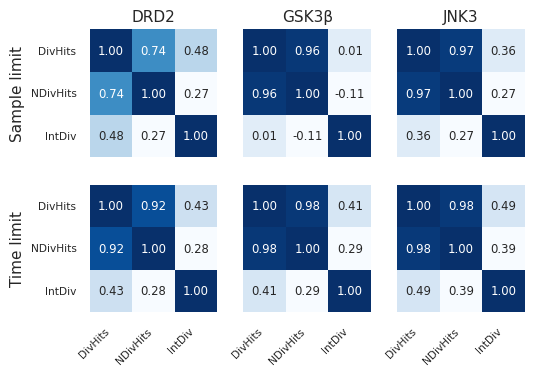

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=0.7)
r = 0.9
fig, axes = plt.subplots(2, 3, figsize=(6 * r, 4.4 * r), sharex=True, sharey=True)

limit_name_dict = {"samples": "Sample limit", "time": "Time limit"}

for i, limit_name in enumerate(limit_names):
    df = df_mean_dict[limit_name]
    # drop Hits
    df = df.iloc[:, df.columns.get_level_values(1) != "Hits"]
    for j, task_name in enumerate(df.columns.get_level_values(0).unique()):
        plt.sca(axes[i, j])
        corr_matrix = df[task_name].corr(method="pearson")

        sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", square=True, cbar=False)
        plt.xticks(rotation=45, horizontalalignment="right")
        # plt.yticks(rotation=45, verticalalignment='top');
        plt.xlabel(None)
        plt.ylabel(None)
        axes[0][j].set_title(task_name, fontsize=11)

    axes[i][0].set_ylabel(limit_name_dict[limit_name], fontsize=11)

plt.tight_layout()
plt.savefig("figures/correlation_div_metrics.pdf", bbox_inches="tight")